In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
import copy
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
font_location = 'C:/WINDOWS/Fonts/SeoulHangangB.ttf'
font_name = fm.FontProperties(fname = font_location).get_name()
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error

In [249]:
# pandas 함수를 통해 csv 파일을 불러온다.
# 인코딩에 문제가 있으므로 "CP949"로 지정해준다.
# 석식계가 0 명인 석식메뉴에는 "조기퇴근의 날"과 같은 특별한 사유가 적혀 있다.
# 그러므로 이를 추출한다.
df = pd.read_csv("train.csv", encoding="CP949")
no_dinner_menu = set(df.loc[(df["석식계"]==0), "석식메뉴"])


# 데이터프레임 시각화를 위해 '일자' column을 index로 변환한다.
df['일자'] = pd.to_datetime(df['일자'])
df.set_index('일자', drop=False, inplace=True)
df.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
일자,,,,,,,,,,,,
2016-02-01,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0
2016-02-02,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0
2016-02-03,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0
2016-02-04,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0
2016-02-05,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0


In [250]:
# 요구사항: '일자' column에서 year, month, day 정보를 추출해 별도의 column으로 생성한다.
def date_transformation(given):
    given['일자'] = pd.to_datetime(given['일자'])
    given.set_index('일자', drop=False, inplace=True)
    
    given['year'] = pd.to_datetime(dt['일자'])
    given['month'] = pd.to_datetime(dt['일자'])
    given['day'] = pd.to_datetime(dt['일자'])


    given['year'] = pd.to_numeric(given['year'].dt.year)
    given['month'] = pd.to_numeric(given['month'].dt.month)
    given['day'] = pd.to_numeric(given['day'].dt.day)
    return given

In [251]:
# 요구사항: '요일' column을 통해 전날휴무와 뒷날휴무 여부를 0과 1로 표시하는 column을 추가 생성한다.
def prior_posterior(given):
    given["전날휴무"] = given["요일"].shift(1).fillna(0)
    given["뒷날휴무"] = given["요일"].shift(-1).fillna(0)
  
    # 전후날 근무날이면 0으로 표시하기
    given.loc[(given["요일"]=="월") & (given["뒷날휴무"]=="화"), "뒷날휴무"] = 0
    given.loc[(given["요일"]=="화") & (given["뒷날휴무"]=="수"), "뒷날휴무"] = 0
    given.loc[(given["요일"]=="수") & (given["뒷날휴무"]=="목"), "뒷날휴무"] = 0
    given.loc[(given["요일"]=="목") & (given["뒷날휴무"]=="금"), "뒷날휴무"] = 0
    given.loc[(given["요일"]=="화") & (given["전날휴무"]=="월"), "전날휴무"] = 0
    given.loc[(given["요일"]=="수") & (given["전날휴무"]=="화"), "전날휴무"] = 0
    given.loc[(given["요일"]=="목") & (given["전날휴무"]=="수"), "전날휴무"] = 0
    given.loc[(given["요일"]=="금") & (given["전날휴무"]=="목"), "전날휴무"] = 0
    given.loc[given["전날휴무"] != 0, "전날휴무"] = 1
    given.loc[given["뒷날휴무"] != 0, "뒷날휴무"] = 1

    return given

In [252]:
# 석식메뉴에 "조기퇴근의 날"과 같은 표시가 되어 있으면 0으로 변환한다.
def no_work(given):
    given["일찍마침"] = given["석식메뉴"].map(lambda x: 1 if x in no_dinner_menu else 0)
    return given

In [253]:
# "요일"을 code로 나타낸다.
# one_hot encoding을 원할 경우 다중공선성을 위해 첫번째 column을 drop하도록 multi_coll=True 설정을 할 수 있다.
def day_process(given, one_hot = False, multi_coll = False):
    if one_hot == False:
        given.loc[given["요일"]=="월", "요일"] = 0
        given.loc[given["요일"]=="화", "요일"] = 1
        given.loc[given["요일"]=="수", "요일"] = 2
        given.loc[given["요일"]=="목", "요일"] = 3
        given.loc[given["요일"]=="금", "요일"] = 4
        return given
    elif multi_coll == True:
        given = pd.get_dummies(given, columns=['요일'], drop_first=True)
        return given
    else:
        given = pd.get_dummies(given, columns=['요일'], drop_first=False)
        return given

In [254]:
# need_col에 저장된 column만을 추출한다.
def col_selection(given, test=False):
    need_col = ['year', 'month', 'day', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
        '현본사소속재택근무자수', '전날휴무', '뒷날휴무', '일찍마침', '중식계', '석식계' ]
    if test == False:
        return given[need_col]
    if test == True:
        need_col.remove('중식계')
        need_col.remove('석식계')
        return given[need_col]

In [255]:
# 상기 표시된 함수들로 전처리 한다.
# test = True이면 '석식계', '중식계' column이 없음을 인지하고 자체 처리한다.
def total_preprocess(given, test=False):
    given = prior_posterior(given)
    given = no_work(given)
    given = day_process(given, one_hot=False, multi_coll=False)
    given = date_transformation(given)
    given = col_selection(given, test=test)
    return given

In [261]:
# 인코딩 UTF-8이 아니므로 지정하여 불러옴
dt = pd.read_csv("train.csv", encoding="CP949")

train = total_preprocess(dt)
train_target = train[['중식계', '석식계']]
collect_col = copy.deepcopy(train.columns)
train_column = collect_col.drop('중식계').drop('석식계')
train = train[train_column]
test = pd.read_csv("test.csv")
test = total_preprocess(test, test=True)



# X1_train, X1_test, y1_train, y1_test = train_test_split(train, train_target["중식계"], shuffle=True)
# lunch_test = copy.deepcopy(test)
# X2_train, X2_test, y2_train, y2_test = train_test_split(train, train_target["석식계"], shuffle=True)
# dinner_test = copy.deepcopy(test)

# 년만 학습 시키기
X1_train, X1_test = train['2020'], train['2021']
y1_train, y1_test = train_target['2020']["중식계"], train_target['2021']["중식계"]
X2_train, X2_test = train['2020'], train['2021']
y2_train, y2_test = train_target['2020']["석식계"], train_target['2021']["석식계"]

In [262]:
from sklearn.preprocessing import PolynomialFeatures
# degree=3, include_bias = False
from sklearn.feature_selection import RFE

In [263]:
pipe = Pipeline([('poly', None), ('preprocessing', None), ('rfe', None), ('regressor', None)])

hyperparam_grid = [
    {'regressor':[Lasso()], 'regressor__alpha':[0.01, 1, 10],
    'rfe':[RFE(Lasso())], 'rfe__n_features_to_select': [None, 3, 5, 10, 15, 20], 'rfe__estimator__alpha':[0.01, 1, 10],
    'preprocessing': [None, MinMaxScaler(), StandardScaler()],
    'poly': [PolynomialFeatures()], 'poly__degree':[1], 'poly__include_bias':[False]
    }]

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

grid1 = GridSearchCV(pipe, hyperparam_grid, scoring="neg_mean_absolute_error",
                   refit=True, cv=kfold)
grid2 = GridSearchCV(pipe, hyperparam_grid, scoring="neg_mean_absolute_error",
                   refit=True, cv=kfold)

In [264]:
grid1.fit(X1_train, y1_train)
print(grid1.best_estimator_)
print(grid1.best_params_)
print(grid1.best_score_)
print(grid1.score(X1_test, y1_test))

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('preprocessing', None),
                ('rfe',
                 RFE(estimator=Lasso(alpha=0.01), n_features_to_select=10)),
                ('regressor', Lasso(alpha=0.01))])
{'poly': PolynomialFeatures(degree=1, include_bias=False), 'poly__degree': 1, 'poly__include_bias': False, 'preprocessing': None, 'regressor': Lasso(alpha=0.01), 'regressor__alpha': 0.01, 'rfe': RFE(estimator=Lasso(alpha=0.01), n_features_to_select=10), 'rfe__estimator__alpha': 0.01, 'rfe__n_features_to_select': 10}
-77.4889273883463
-131.17908442962676


In [265]:
grid2.fit(X2_train, y2_train)
print(grid2.best_estimator_)
print(grid2.best_params_)
print(grid2.best_score_)
print(grid2.score(X2_test, y2_test))

Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('preprocessing', MinMaxScaler()),
                ('rfe',
                 RFE(estimator=Lasso(alpha=10), n_features_to_select=10)),
                ('regressor', Lasso(alpha=0.01))])
{'poly': PolynomialFeatures(degree=1, include_bias=False), 'poly__degree': 1, 'poly__include_bias': False, 'preprocessing': MinMaxScaler(), 'regressor': Lasso(alpha=0.01), 'regressor__alpha': 0.01, 'rfe': RFE(estimator=Lasso(alpha=10), n_features_to_select=10), 'rfe__estimator__alpha': 10, 'rfe__n_features_to_select': 10}
-55.06090317329667
-91.28327225283684


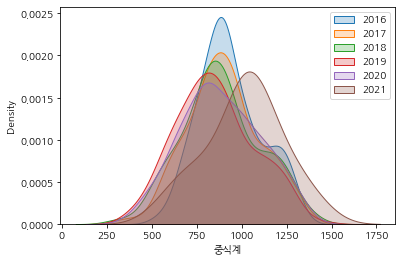

In [128]:
sns.kdeplot(train_target['2016']['중식계'], shade = True)
sns.kdeplot(train_target['2017']['중식계'], shade = True)
sns.kdeplot(train_target['2018']['중식계'], shade = True)
sns.kdeplot(train_target['2019']['중식계'], shade = True)
sns.kdeplot(train_target['2020']['중식계'], shade = True)
sns.kdeplot(train_target['2021']['중식계'], shade = True)
plt.legend(labels=['2016', '2017', '2018', '2019', '2020', '2021'])
plt.show()

2016년은 버리는 게 좋을 것 같음 2017~2020년까지의 중식계 인원 분포의 형태가 아예 다름.
또한 2020년, 2021년의 분포도 차이가 나는데 코로나 효과도 존재하는 것으로 판단된다.

In [207]:
print(train_target["2016"].mean())
print(train_target["2017"].mean())
print(train_target["2018"].mean())
print(train_target["2019"].mean())
print(train_target["2020"].mean())
print(train_target["2021"].mean())

중식계    932.792952
석식계    519.418502
dtype: float64
중식계    897.614754
석식계    457.049180
dtype: float64
중식계    882.903766
석식계    463.539749
dtype: float64
중식계    850.512195
석식계    445.386179
dtype: float64
중식계    882.267241
석식계    430.668103
dtype: float64
중식계    1009.705882
석식계     396.588235
dtype: float64


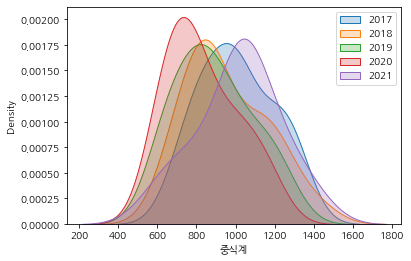

In [133]:
sns.kdeplot(train_target['2017-01']['중식계'], shade = True)
sns.kdeplot(train_target['2018-01']['중식계'], shade = True)
sns.kdeplot(train_target['2019-01']['중식계'], shade = True)
sns.kdeplot(train_target['2020-01']['중식계'], shade = True)
sns.kdeplot(train_target['2021-01']['중식계'], shade = True)
plt.legend(labels=['2017', '2018', '2019', '2020', '2021'])
plt.show()

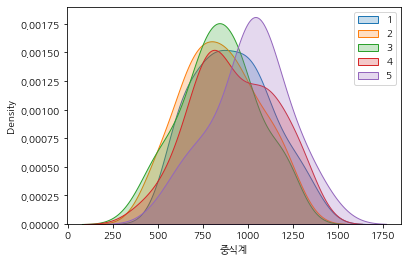

In [201]:
sns.kdeplot(train_target['2020-01':'2020-03']['중식계'], shade = True)
sns.kdeplot(train_target['2020-04':'2020-06']['중식계'], shade = True)
sns.kdeplot(train_target['2020-07':'2020-09']['중식계'], shade = True)
sns.kdeplot(train_target['2020-10':'2020-12']['중식계'], shade = True)
sns.kdeplot(train_target['2021-01']['중식계'], shade = True)
plt.legend(labels=[1, 2, 3, 4, 5])
plt.show()

<AxesSubplot:xlabel='updated'>

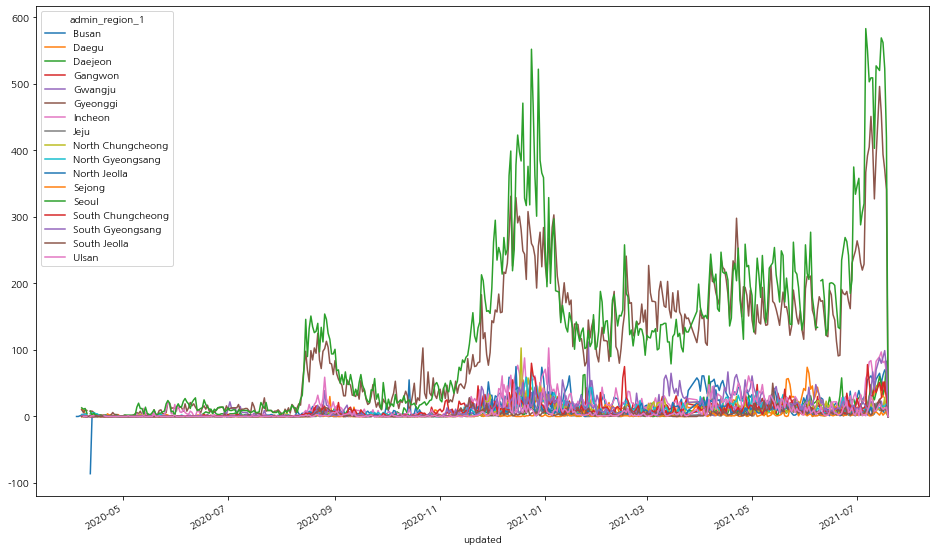

In [225]:
dk= pd.read_csv("bing_covid-19_data.csv")
df_korea = dk[(dk['country_region']=='South Korea') & (~dk.admin_region_1.isnull())]
df_korea['updated'] = pd.to_datetime(df_korea['updated'])
data_pivot_by_date = df_korea.pivot(index='updated', columns='admin_region_1', values='confirmed_change')
data_pivot_by_date.plot(figsize=(16, 10))

<AxesSubplot:xlabel='일자'>

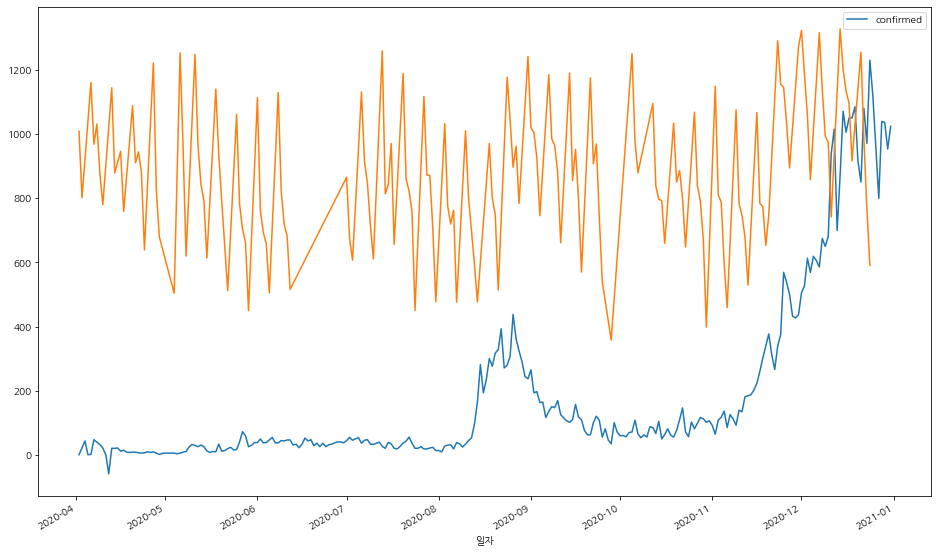

In [236]:
pk = pd.DataFrame(data_pivot_by_date.sum(axis=1), columns=['confirmed'])
pk['2020-04':'2020-12'].plot(figsize=(16,10))
train_target['2020-04-02':'2020-12']['중식계'].plot(figsize=(16,10))

<AxesSubplot:xlabel='일자'>

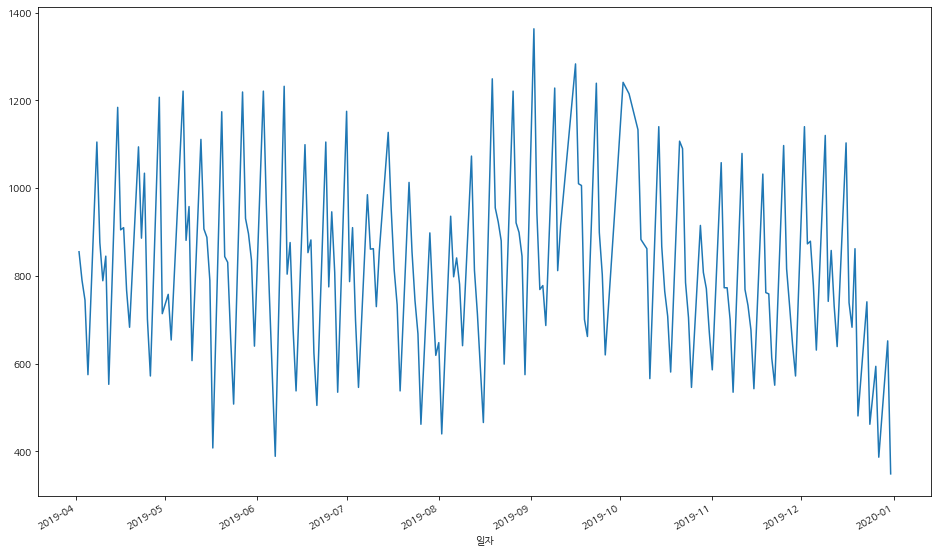

In [238]:
train_target['2019-04-02':'2019-12']['중식계'].plot(figsize=(16,10))